# Monthly Win Probability Prediction for CRM Opportunities

This notebook implements a specialized model to predict the probability of winning opportunities in the next month. It focuses on:

1. **Time-based Features**: Using engagement dates and sales cycle patterns
2. **Monthly Predictions**: Predicting win probability for opportunities likely to close in the next 30 days
3. **Business Intelligence**: Providing actionable insights for sales teams

**Objective**: Build a model to predict which opportunities have the highest probability of winning in the next month, helping sales teams prioritize their efforts.

**Key Metrics**: 
- Win probability score (0-1)
- Expected close timeframe
- Risk assessment
- Revenue impact

## 1. Import Required Libraries

In [1]:
# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import calendar

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, 
    brier_score_loss
)

# XGBoost for advanced modeling
import xgboost as xgb

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature

# Configuration
import sys
sys.path.append('/Users/vrabinin/Documents/Github/mlops-zoomcamp-project')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')
print(mlflow.__version__)


3.1.1


## 2. Load and Prepare Data for Monthly Predictions

In [2]:
# Set up MLflow tracking for version 3.x
mlflow.set_tracking_uri('http://localhost:5005')

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow version: {mlflow.__version__}")

# Load the CRM dataset
data_path = Path('../data/features/crm_features.csv')
print(f"Loading data from: {data_path}")

df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")

# Convert date columns
df['engage_date'] = pd.to_datetime(df['engage_date'])
df['close_date'] = pd.to_datetime(df['close_date'])

print(f"Date range: {df['engage_date'].min()} to {df['engage_date'].max()}")
print(f"Dataset overview: {df.shape[0]:,} opportunities")

MLflow tracking URI: http://localhost:5005
MLflow version: 3.1.1
Loading data from: ../data/features/crm_features.csv
Dataset shape: (8800, 88)
Date range: 2016-10-20 00:00:00 to 2017-12-27 00:00:00
Dataset overview: 8,800 opportunities


In [3]:
# Create monthly prediction features
def create_monthly_features(df):
    """Create features specifically for monthly win probability prediction"""
    
    # Current date simulation (use last date in dataset + 1 month for realistic simulation)
    current_date = df['engage_date'].max() + timedelta(days=30)
    print(f"Simulating predictions for: {current_date.strftime('%Y-%m-%d')}")
    
    # Calculate days since engagement
    df['days_since_engage'] = (current_date - df['engage_date']).dt.days
    
    # Expected close timeframe based on historical patterns
    avg_sales_cycle = df[df['is_closed'] == 1]['sales_cycle_days'].median()
    df['expected_close_date'] = df['engage_date'] + timedelta(days=avg_sales_cycle)
    df['days_to_expected_close'] = (df['expected_close_date'] - current_date).dt.days
    
    # Monthly prediction flags
    df['should_close_next_month'] = df['days_to_expected_close'].between(-15, 45)  # Some buffer
    df['is_overdue'] = df['days_to_expected_close'] < -30
    df['is_early_stage'] = df['days_to_expected_close'] > 60
    
    # Time-based features
    df['engage_month_name'] = df['engage_date'].dt.month_name()
    df['engage_weekday'] = df['engage_date'].dt.day_name()
    df['engage_is_quarter_end'] = df['engage_date'].dt.month.isin([3, 6, 9, 12])
    df['engage_is_year_end'] = df['engage_date'].dt.month == 12
    
    # Sales velocity features
    df['sales_velocity'] = df['close_value'] / df['sales_cycle_days']
    df['sales_velocity'] = df['sales_velocity'].fillna(0)
    
    # Risk factors
    df['high_value_deal'] = df['close_value'] > df['close_value'].quantile(0.8)
    df['long_sales_cycle'] = df['sales_cycle_days'] > df['sales_cycle_days'].quantile(0.8)
    
    return df

df_monthly = create_monthly_features(df.copy())

print("Monthly prediction features created:")
print(f"- Opportunities that should close next month: {df_monthly['should_close_next_month'].sum():,}")
print(f"- Overdue opportunities: {df_monthly['is_overdue'].sum():,}")
print(f"- Early stage opportunities: {df_monthly['is_early_stage'].sum():,}")

Simulating predictions for: 2018-01-26
Monthly prediction features created:
- Opportunities that should close next month: 145
- Overdue opportunities: 8,008
- Early stage opportunities: 0


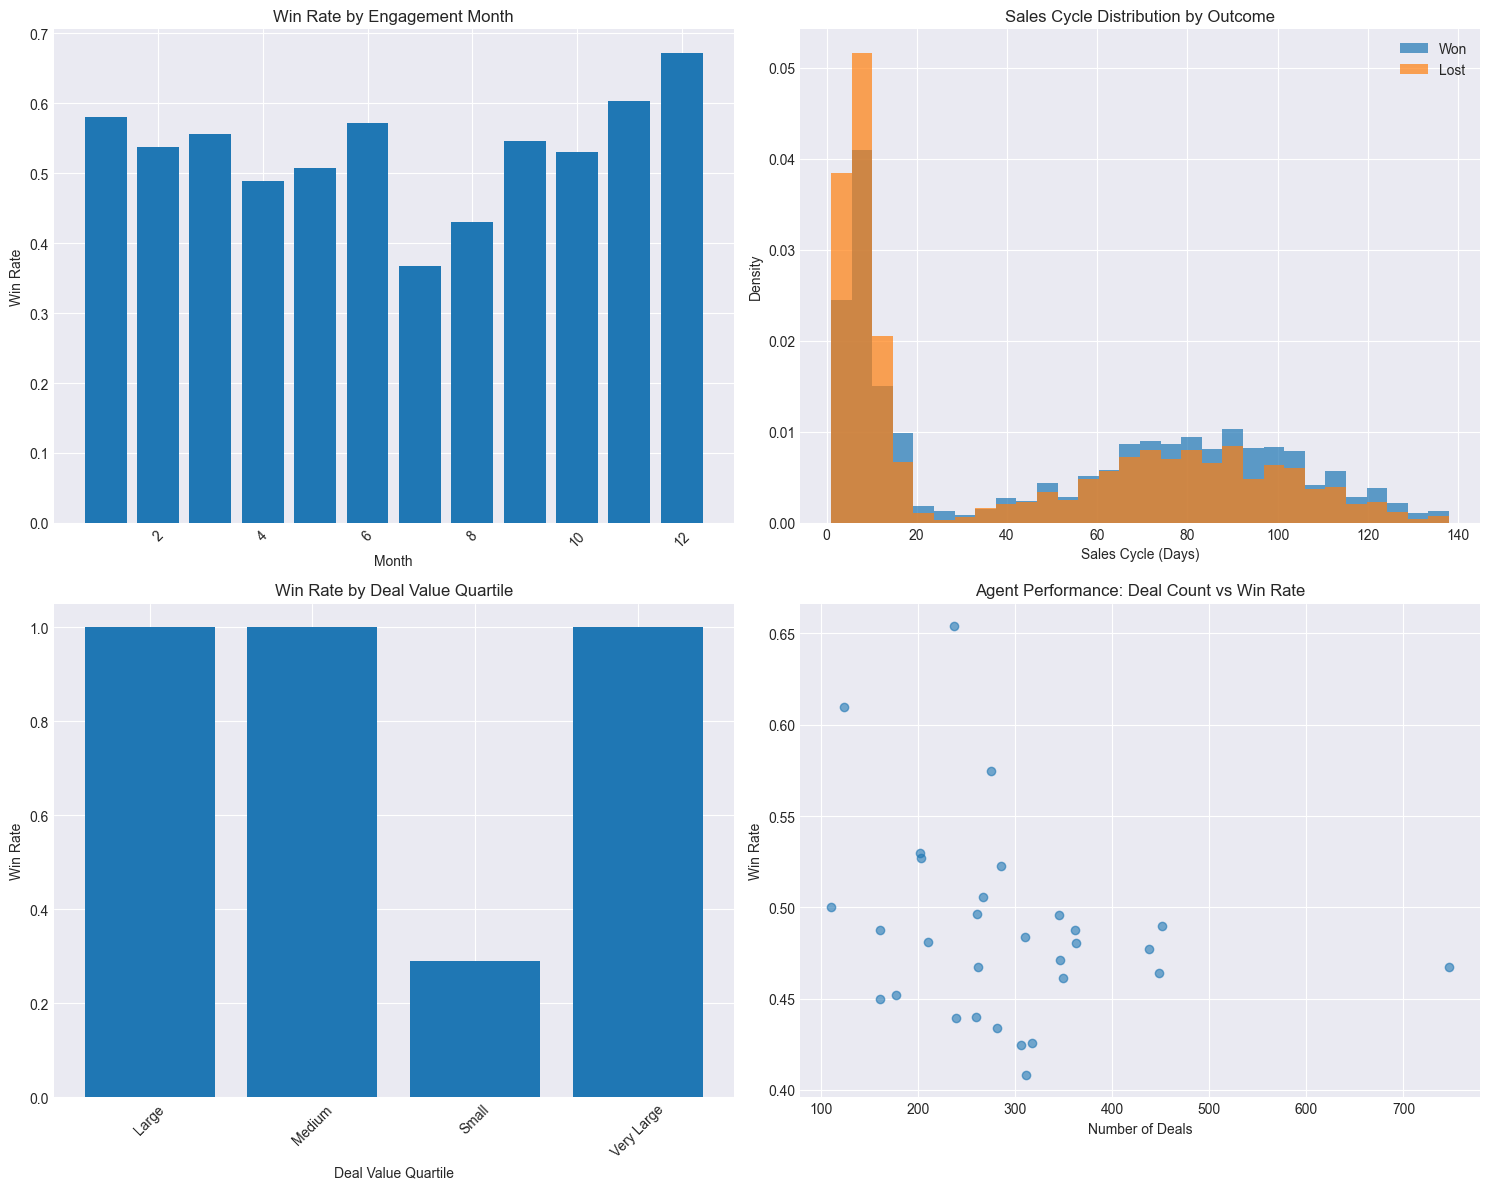

Monthly Patterns Analysis:
              total_opps  wins  win_rate  avg_value
engage_month                                       
1.0                  312   181     0.580   1407.471
2.0                  515   277     0.538   1558.870
3.0                  792   440     0.556   1349.345
4.0                  874   427     0.489   1249.943
5.0                  722   366     0.507   1268.540
6.0                  792   453     0.572   1430.141
7.0                 1198   441     0.368   1034.154
8.0                  793   341     0.430   1042.120
9.0                  779   425     0.546   1393.058
10.0                 768   407     0.530   1357.230
11.0                 398   240     0.603   1530.555
12.0                 357   240     0.672   1405.829


In [4]:
# Analyze monthly patterns for better understanding
def analyze_monthly_patterns(df):
    """Analyze patterns in monthly opportunity outcomes"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Win rate by month
    monthly_stats = df.groupby('engage_month').agg({
        'is_won': ['count', 'sum', 'mean'],
        'close_value': 'mean'
    }).round(3)
    
    monthly_stats.columns = ['total_opps', 'wins', 'win_rate', 'avg_value']
    
    axes[0, 0].bar(monthly_stats.index, monthly_stats['win_rate'])
    axes[0, 0].set_title('Win Rate by Engagement Month')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Win Rate')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Sales cycle distribution
    won_deals = df[df['is_won'] == 1]
    lost_deals = df[df['is_lost'] == 1]
    
    axes[0, 1].hist(won_deals['sales_cycle_days'], bins=30, alpha=0.7, label='Won', density=True)
    axes[0, 1].hist(lost_deals['sales_cycle_days'], bins=30, alpha=0.7, label='Lost', density=True)
    axes[0, 1].set_title('Sales Cycle Distribution by Outcome')
    axes[0, 1].set_xlabel('Sales Cycle (Days)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    
    # 3. Deal value vs win probability - Fixed with duplicates handling
    try:
        #value_bins = pd.qcut(df['close_value'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')
        #value_win_rate = df.groupby(value_bins)['is_won'].mean()

        value_win_rate = df.groupby('close_value_category')['is_won'].mean()

        axes[1, 0].bar(range(len(value_win_rate)), value_win_rate.values)
        axes[1, 0].set_title('Win Rate by Deal Value Quartile')
        axes[1, 0].set_xlabel('Deal Value Quartile')
        axes[1, 0].set_ylabel('Win Rate')
        axes[1, 0].set_xticks(range(len(value_win_rate)))
        axes[1, 0].set_xticklabels(value_win_rate.index, rotation=45)
    except ValueError as e:
        # Fallback to simple binning if qcut still fails
        print(f"Using fallback binning due to: {e}")
        df['value_category'] = 'Medium'  # Simple fallback
        df.loc[df['close_value'] <= df['close_value'].quantile(0.2), 'value_category'] = 'Very Low'
        df.loc[df['close_value'] <= df['close_value'].quantile(0.4), 'value_category'] = 'Low'
        df.loc[df['close_value'] >= df['close_value'].quantile(0.8), 'value_category'] = 'Very High'
        df.loc[df['close_value'] >= df['close_value'].quantile(0.6), 'value_category'] = 'High'
        
        value_win_rate = df.groupby('value_category')['is_won'].mean()
        axes[1, 0].bar(range(len(value_win_rate)), value_win_rate.values)
        axes[1, 0].set_title('Win Rate by Deal Value Category')
        axes[1, 0].set_xlabel('Deal Value Category')
        axes[1, 0].set_ylabel('Win Rate')
        axes[1, 0].set_xticks(range(len(value_win_rate)))
        axes[1, 0].set_xticklabels(value_win_rate.index, rotation=45)
    
    # 4. Agent performance distribution
    agent_stats = df.groupby('sales_agent')['is_won'].agg(['count', 'mean']).reset_index()
    agent_stats = agent_stats[agent_stats['count'] >= 10]  # Agents with at least 10 deals
    
    axes[1, 1].scatter(agent_stats['count'], agent_stats['mean'], alpha=0.6)
    axes[1, 1].set_title('Agent Performance: Deal Count vs Win Rate')
    axes[1, 1].set_xlabel('Number of Deals')
    axes[1, 1].set_ylabel('Win Rate')
    
    plt.tight_layout()
    plt.show()
    
    return monthly_stats, agent_stats

monthly_patterns, agent_performance = analyze_monthly_patterns(df_monthly)
print("Monthly Patterns Analysis:")
print(monthly_patterns)

## 3. Prepare Training Data for Monthly Win Prediction

In [5]:
# Focus on opportunities that should close within a reasonable timeframe
# This simulates the real-world scenario where we want to predict next month's wins

def prepare_monthly_prediction_data(df):
    """Prepare data specifically for monthly win probability prediction"""
    
    # Filter to opportunities that are in a predictable timeframe
    # We'll train on historical data and predict on current pipeline
    training_data = df[
        (df['is_closed'] == 1) |  # Include all closed deals for training
        (df['should_close_next_month'] == True)  # Include current pipeline
    ].copy()
    
    print(f"Training data size: {len(training_data):,} opportunities")
    print(f"Closed deals: {training_data['is_closed'].sum():,}")
    print(f"Open deals for prediction: {(training_data['is_closed'] == 0).sum():,}")
    
    # Define features for monthly prediction
    monthly_features = [
        # Deal characteristics
        'close_value_log', 'close_value_category_encoded',
        
        # Time-based features
        'days_since_engage', 'sales_cycle_days', 
        'engage_month', 'engage_quarter', 'engage_day_of_week',
        
        # Agent and product performance
        'agent_win_rate', 'agent_opportunity_count',
        'product_win_rate', 'product_popularity',
        
        # Account features
        'revenue', 'employees', 'is_repeat_account', 'account_frequency',
        
        # Temporal risk factors
        'should_close_next_month', 'is_overdue', 'is_early_stage',
        'high_value_deal', 'long_sales_cycle',
        
        # Velocity and momentum
        'sales_velocity',
        
        # Categorical encodings
        'sales_agent_encoded', 'product_encoded', 'account_encoded',
        'manager_encoded', 'regional_office_encoded', 'sector_encoded'
    ]
    
    # Handle missing values in sales_velocity and other computed features
    for col in ['sales_velocity', 'days_since_engage']:
        if col in training_data.columns:
            training_data[col] = training_data[col].fillna(training_data[col].median())
    
    # Select features that exist in the dataset
    available_features = [f for f in monthly_features if f in training_data.columns]
    missing_features = [f for f in monthly_features if f not in training_data.columns]
    
    if missing_features:
        print(f"Missing features: {missing_features}")
    
    print(f"Using {len(available_features)} features for monthly prediction")
    
    X = training_data[available_features].copy()
    y = training_data['is_won'].copy()  # Predict win probability
    
    # Handle any remaining missing values
    X = X.fillna(X.median())
    
    return X, y, training_data, available_features

X_monthly, y_monthly, df_training, feature_list = prepare_monthly_prediction_data(df_monthly)

print(f"\nMonthly prediction dataset:")
print(f"Features: {X_monthly.shape[1]}")
print(f"Samples: {X_monthly.shape[0]:,}")
print(f"Win rate: {y_monthly.mean():.3f}")
print(f"Feature list: {feature_list[:10]}...") # Show first 10 features

Training data size: 6,733 opportunities
Closed deals: 6,711
Open deals for prediction: 22
Using 27 features for monthly prediction

Monthly prediction dataset:
Features: 27
Samples: 6,733
Win rate: 0.629
Feature list: ['close_value_log', 'close_value_category_encoded', 'days_since_engage', 'sales_cycle_days', 'engage_month', 'engage_quarter', 'engage_day_of_week', 'agent_win_rate', 'agent_opportunity_count', 'product_win_rate']...


In [6]:
# Split data for monthly prediction training
# Note: For monthly predictions, we need to be careful about temporal splits

def create_temporal_split(X, y, df_training, test_size=0.2):
    """Create a temporal split that respects time ordering"""
    
    # For closed deals, use temporal split
    closed_mask = df_training['is_closed'] == 1
    open_mask = df_training['is_closed'] == 0
    
    # Split closed deals temporally
    closed_data = df_training[closed_mask].sort_values('close_date')
    split_idx = int(len(closed_data) * (1 - test_size))
    
    train_indices = list(closed_data.index[:split_idx])
    test_indices = list(closed_data.index[split_idx:])
    
    # Add some open deals to training (for current pipeline context)
    open_indices = list(df_training[open_mask].index)
    if len(open_indices) > 0:
        # Add 80% of open deals to training, 20% to test
        open_split = int(len(open_indices) * 0.8)
        train_indices.extend(open_indices[:open_split])
        test_indices.extend(open_indices[open_split:])
    
    # Create train/test sets
    X_train = X.loc[train_indices]
    X_test = X.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_temporal_split(X_monthly, y_monthly, df_training)

print("Temporal Split Results:")
print(f"Training set: {len(X_train):,} samples, win rate: {y_train.mean():.3f}")
print(f"Test set: {len(X_test):,} samples, win rate: {y_test.mean():.3f}")
print(f"Features: {X_train.shape[1]}")

Temporal Split Results:
Training set: 5,385 samples, win rate: 0.625
Test set: 1,348 samples, win rate: 0.646
Features: 27


## 4. Train Calibrated Models for Probability Prediction

In [7]:
#show mlflow configuration
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow version: {mlflow.__version__}")

MLflow tracking URI: http://localhost:5005
MLflow version: 3.1.1


In [12]:
# Monthly win probability models with calibration
def train_monthly_win_models(X_train, y_train, X_test, y_test):
    """Train and calibrate models specifically for monthly win probability prediction"""
    
    models = {
        'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
        'random_forest': RandomForestClassifier(n_estimators=200, random_state=42),
        'xgboost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'gradient_boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    
    print("Training Monthly Win Probability Models:")
    print("=" * 60)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        with mlflow.start_run(run_name=f"monthly_win_prob_{name}"):
            # Train base model
            model.fit(X_train, y_train)
            
            # Calibrate probabilities using isotonic regression
            calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
            calibrated_model.fit(X_train, y_train)
            
            # Predictions
            y_pred = calibrated_model.predict(X_test)
            y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]
            
            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            brier_score = brier_score_loss(y_test, y_pred_proba)
            
            # Log metrics
            mlflow.log_param("model_type", name)
            mlflow.log_param("calibration", "isotonic")
            mlflow.log_param("train_size", len(X_train))
            mlflow.log_param("test_size", len(X_test))
            
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("roc_auc", roc_auc)
            mlflow.log_metric("brier_score", brier_score)
            
            # Log model - all calibrated models are sklearn objects
            # Note: CalibratedClassifierCV wraps the base model, so always use sklearn logger
            mlflow.sklearn.log_model(
                calibrated_model, 
                name=name,
                input_example=X_test.iloc[:5], 
                signature=infer_signature(X_train, y_train)
            )
            
            results[name] = {
                'model': calibrated_model,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'brier_score': brier_score,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  ROC AUC: {roc_auc:.4f}")
            print(f"  Brier Score: {brier_score:.4f} (lower is better)")
    
    return results

# Train the models
monthly_results = train_monthly_win_models(X_train, y_train, X_test, y_test)

# Display results summary
print("\n" + "="*60)
print("MONTHLY WIN PROBABILITY MODEL RESULTS")
print("="*60)

results_df = pd.DataFrame({
    name: {
        'Accuracy': results['accuracy'],
        'ROC AUC': results['roc_auc'],
        'Brier Score': results['brier_score']
    }
    for name, results in monthly_results.items()
}).T

print(results_df.round(4))

# Find best model based on ROC AUC (important for probability ranking)
best_model_name = results_df['ROC AUC'].idxmax()
best_model = monthly_results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name.upper()}")
print(f"   ROC AUC: {results_df.loc[best_model_name, 'ROC AUC']:.4f}")
print(f"   Brier Score: {results_df.loc[best_model_name, 'Brier Score']:.4f}")

Training Monthly Win Probability Models:

Training logistic_regression...
  Accuracy: 0.9926
  ROC AUC: 0.9987
  Brier Score: 0.0034 (lower is better)
🏃 View run monthly_win_prob_logistic_regression at: http://localhost:5005/#/experiments/2/runs/52fdf59848224412b36d729149e14660
🧪 View experiment at: http://localhost:5005/#/experiments/2

Training random_forest...
  Accuracy: 1.0000
  ROC AUC: 1.0000
  Brier Score: 0.0033 (lower is better)
🏃 View run monthly_win_prob_random_forest at: http://localhost:5005/#/experiments/2/runs/0a68eb2f2e7b43d68fd572c14688cce0
🧪 View experiment at: http://localhost:5005/#/experiments/2

Training xgboost...
  Accuracy: 0.9985
  ROC AUC: 1.0000
  Brier Score: 0.0014 (lower is better)
🏃 View run monthly_win_prob_xgboost at: http://localhost:5005/#/experiments/2/runs/9c319dd4b8434051b968ca0861613e9b
🧪 View experiment at: http://localhost:5005/#/experiments/2

Training gradient_boosting...
  Accuracy: 1.0000
  ROC AUC: 1.0000
  Brier Score: 0.0000 (lower is b

## 5. Probability Calibration Analysis

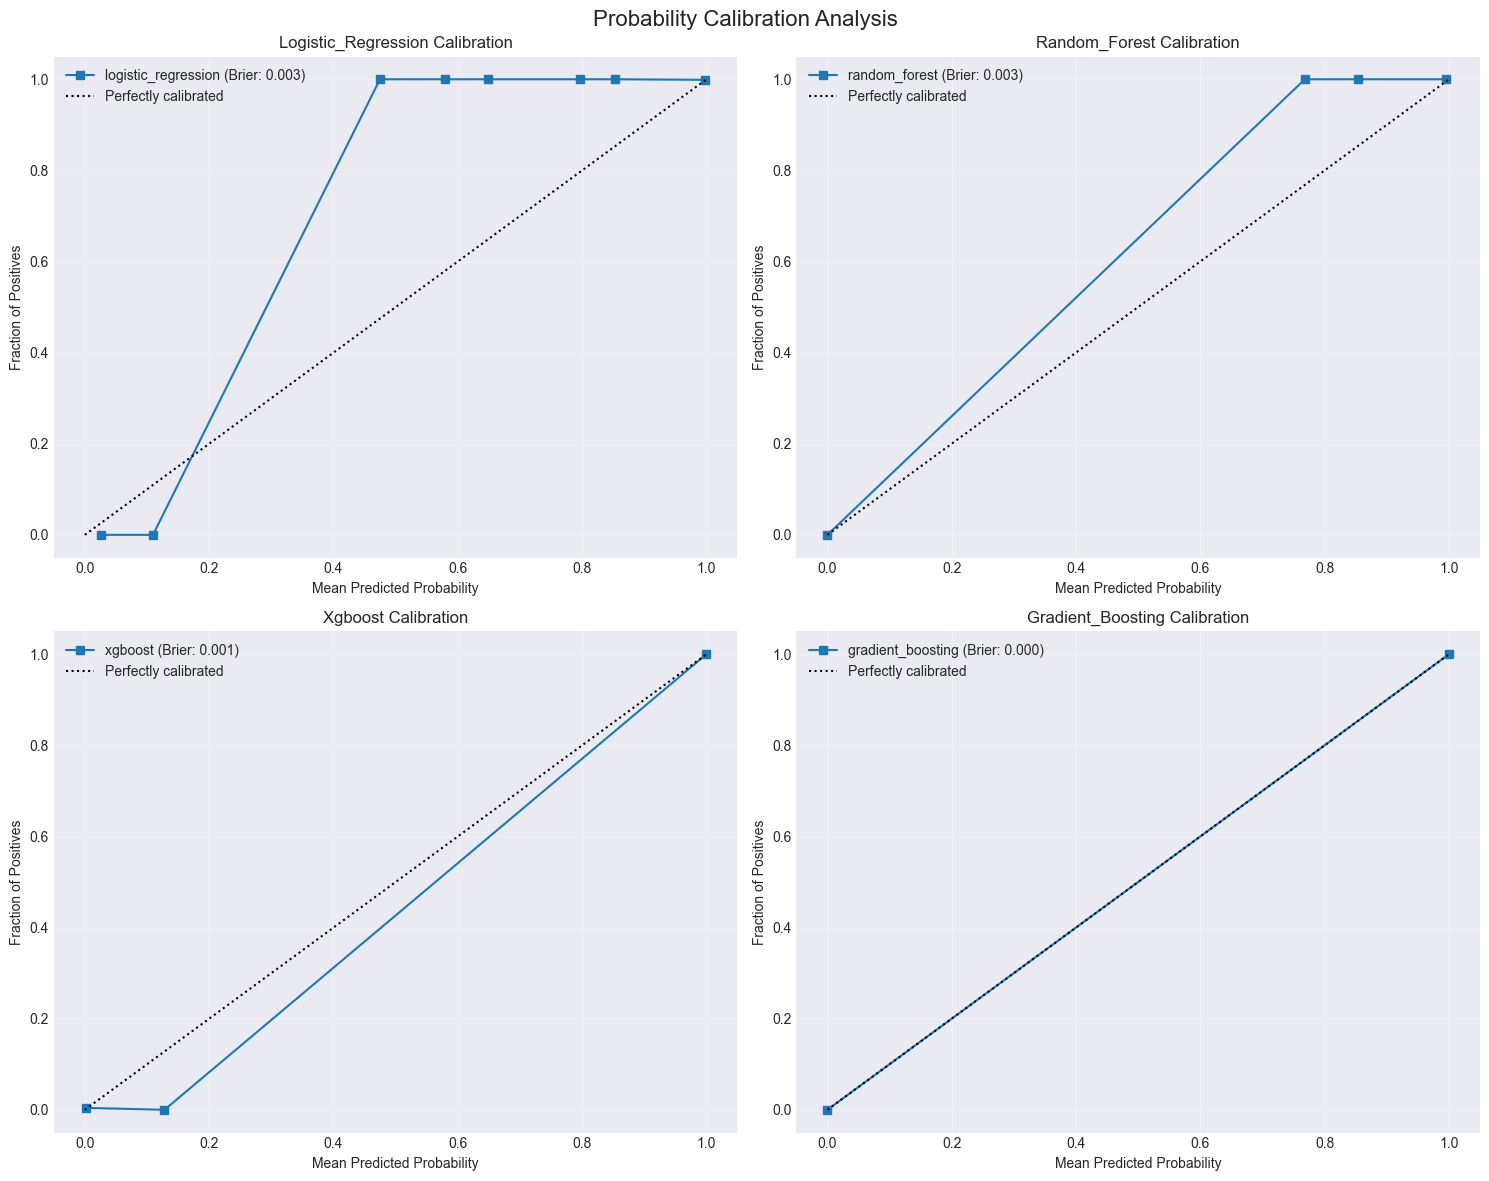

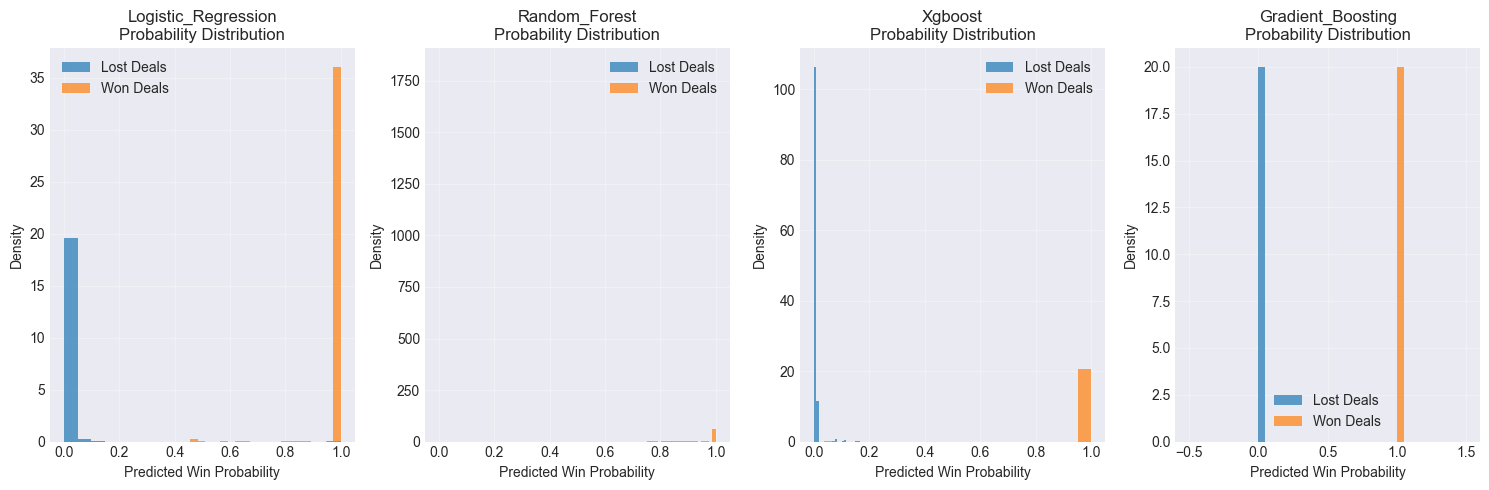

In [13]:
# Analyze probability calibration quality
def analyze_probability_calibration(results, y_test):
    """Analyze how well-calibrated the probability predictions are"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Probability Calibration Analysis', fontsize=16)
    
    for idx, (model_name, result) in enumerate(results.items()):
        if idx >= 4:  # Limit to 4 models
            break
            
        y_proba = result['probabilities']
        
        # Calibration curve (reliability plot)
        row, col = idx // 2, idx % 2
        
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_proba, n_bins=10
        )
        
        axes[row, col].plot(mean_predicted_value, fraction_of_positives, "s-", 
                           label=f"{model_name} (Brier: {result['brier_score']:.3f})")
        axes[row, col].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        axes[row, col].set_xlabel('Mean Predicted Probability')
        axes[row, col].set_ylabel('Fraction of Positives')
        axes[row, col].set_title(f'{model_name.title()} Calibration')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Probability distribution analysis
    plt.figure(figsize=(15, 5))
    
    for idx, (model_name, result) in enumerate(results.items()):
        plt.subplot(1, len(results), idx + 1)
        
        y_proba = result['probabilities']
        
        # Separate probabilities by actual outcome
        win_probs = y_proba[y_test == 1]
        lose_probs = y_proba[y_test == 0]
        
        plt.hist(lose_probs, bins=20, alpha=0.7, label='Lost Deals', density=True)
        plt.hist(win_probs, bins=20, alpha=0.7, label='Won Deals', density=True)
        plt.xlabel('Predicted Win Probability')
        plt.ylabel('Density')
        plt.title(f'{model_name.title()}\nProbability Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_probability_calibration(monthly_results, y_test)

## 6. Generate Monthly Win Probability Predictions

In [14]:
# Create monthly prediction report
def create_monthly_prediction_report(model, X, df_training, feature_list, top_n=50):
    """Create a comprehensive monthly win probability report"""
    
    # Get predictions for all opportunities
    win_probabilities = model.predict_proba(X)[:, 1]
    
    # Create prediction dataframe
    predictions_df = df_training.copy()
    predictions_df['win_probability'] = win_probabilities
    
    # Focus on open opportunities and those likely to close next month
    current_pipeline = predictions_df[
        (predictions_df['is_closed'] == 0) | 
        (predictions_df['should_close_next_month'] == True)
    ].copy()
    
    # Add risk categories
    current_pipeline['probability_category'] = pd.cut(
        current_pipeline['win_probability'],
        bins=[0, 0.3, 0.6, 0.8, 1.0],
        labels=['Low (0-30%)', 'Medium (30-60%)', 'High (60-80%)', 'Very High (80%+)']
    )
    
    # Calculate expected revenue
    current_pipeline['expected_revenue'] = (
        current_pipeline['close_value'] * current_pipeline['win_probability']
    )
    
    # Sort by win probability for prioritization
    current_pipeline = current_pipeline.sort_values('win_probability', ascending=False)
    
    print("MONTHLY WIN PROBABILITY REPORT")
    print("=" * 80)
    print(f"Report Date: {datetime.now().strftime('%Y-%m-%d')}")
    print(f"Total Opportunities in Pipeline: {len(current_pipeline):,}")
    print(f"Total Potential Revenue: ${current_pipeline['close_value'].sum():,.2f}")
    print(f"Expected Revenue (Probability-Weighted): ${current_pipeline['expected_revenue'].sum():,.2f}")
    
    # Summary by probability category
    print("\nOPPORTUNITIES BY WIN PROBABILITY:")
    prob_summary = current_pipeline.groupby('probability_category').agg({
        'win_probability': ['count', 'mean'],
        'close_value': 'sum',
        'expected_revenue': 'sum'
    }).round(2)
    
    prob_summary.columns = ['Count', 'Avg_Probability', 'Total_Value', 'Expected_Revenue']
    print(prob_summary)
    
    # Top opportunities to focus on
    print(f"\nTOP {top_n} OPPORTUNITIES TO PRIORITIZE:")
    print("-" * 80)
    
    top_opportunities = current_pipeline.head(top_n)[
        ['opportunity_id', 'sales_agent', 'account', 'product', 'close_value', 
         'win_probability', 'expected_revenue', 'sales_cycle_days', 'days_since_engage']
    ].round(3)
    
    print(top_opportunities.to_string(index=False))
    
    # Agent performance insights
    print(f"\nAGENT PERFORMANCE INSIGHTS:")
    print("-" * 50)
    
    agent_insights = current_pipeline.groupby('sales_agent').agg({
        'win_probability': ['count', 'mean', 'sum'],
        'expected_revenue': 'sum',
        'close_value': 'sum'
    }).round(3)
    
    agent_insights.columns = ['Pipeline_Count', 'Avg_Win_Prob', 'Total_Win_Prob', 'Expected_Revenue', 'Total_Value']
    agent_insights = agent_insights.sort_values('Expected_Revenue', ascending=False)
    
    print(agent_insights.head(10).to_string())
    
    return current_pipeline, top_opportunities, agent_insights

# Generate the monthly report using the best model
pipeline_predictions, top_opps, agent_insights = create_monthly_prediction_report(
    best_model, X_monthly, df_training, feature_list, top_n=30
)

print(f"\n✅ Monthly prediction report generated successfully!")
print(f"Pipeline opportunities: {len(pipeline_predictions):,}")
print(f"High probability wins (>60%): {(pipeline_predictions['win_probability'] > 0.6).sum()}")

MONTHLY WIN PROBABILITY REPORT
Report Date: 2025-07-26
Total Opportunities in Pipeline: 145
Total Potential Revenue: $206,214.00
Expected Revenue (Probability-Weighted): $165,968.09

OPPORTUNITIES BY WIN PROBABILITY:
                      Count  Avg_Probability  Total_Value  Expected_Revenue
probability_category                                                       
Low (0-30%)               1             0.01        472.0              5.17
Medium (30-60%)           0              NaN          0.0              0.00
High (60-80%)            44             0.77      12991.0          10104.55
Very High (80%+)         52             0.84     182839.0         155858.36

TOP 30 OPPORTUNITIES TO PRIORITIZE:
--------------------------------------------------------------------------------
opportunity_id        sales_agent                      account      product  close_value  win_probability  expected_revenue  sales_cycle_days  days_since_engage
      348COZ5O    Darcel Schlecht Genco Pura Oli

## 7. Visualization and Business Intelligence

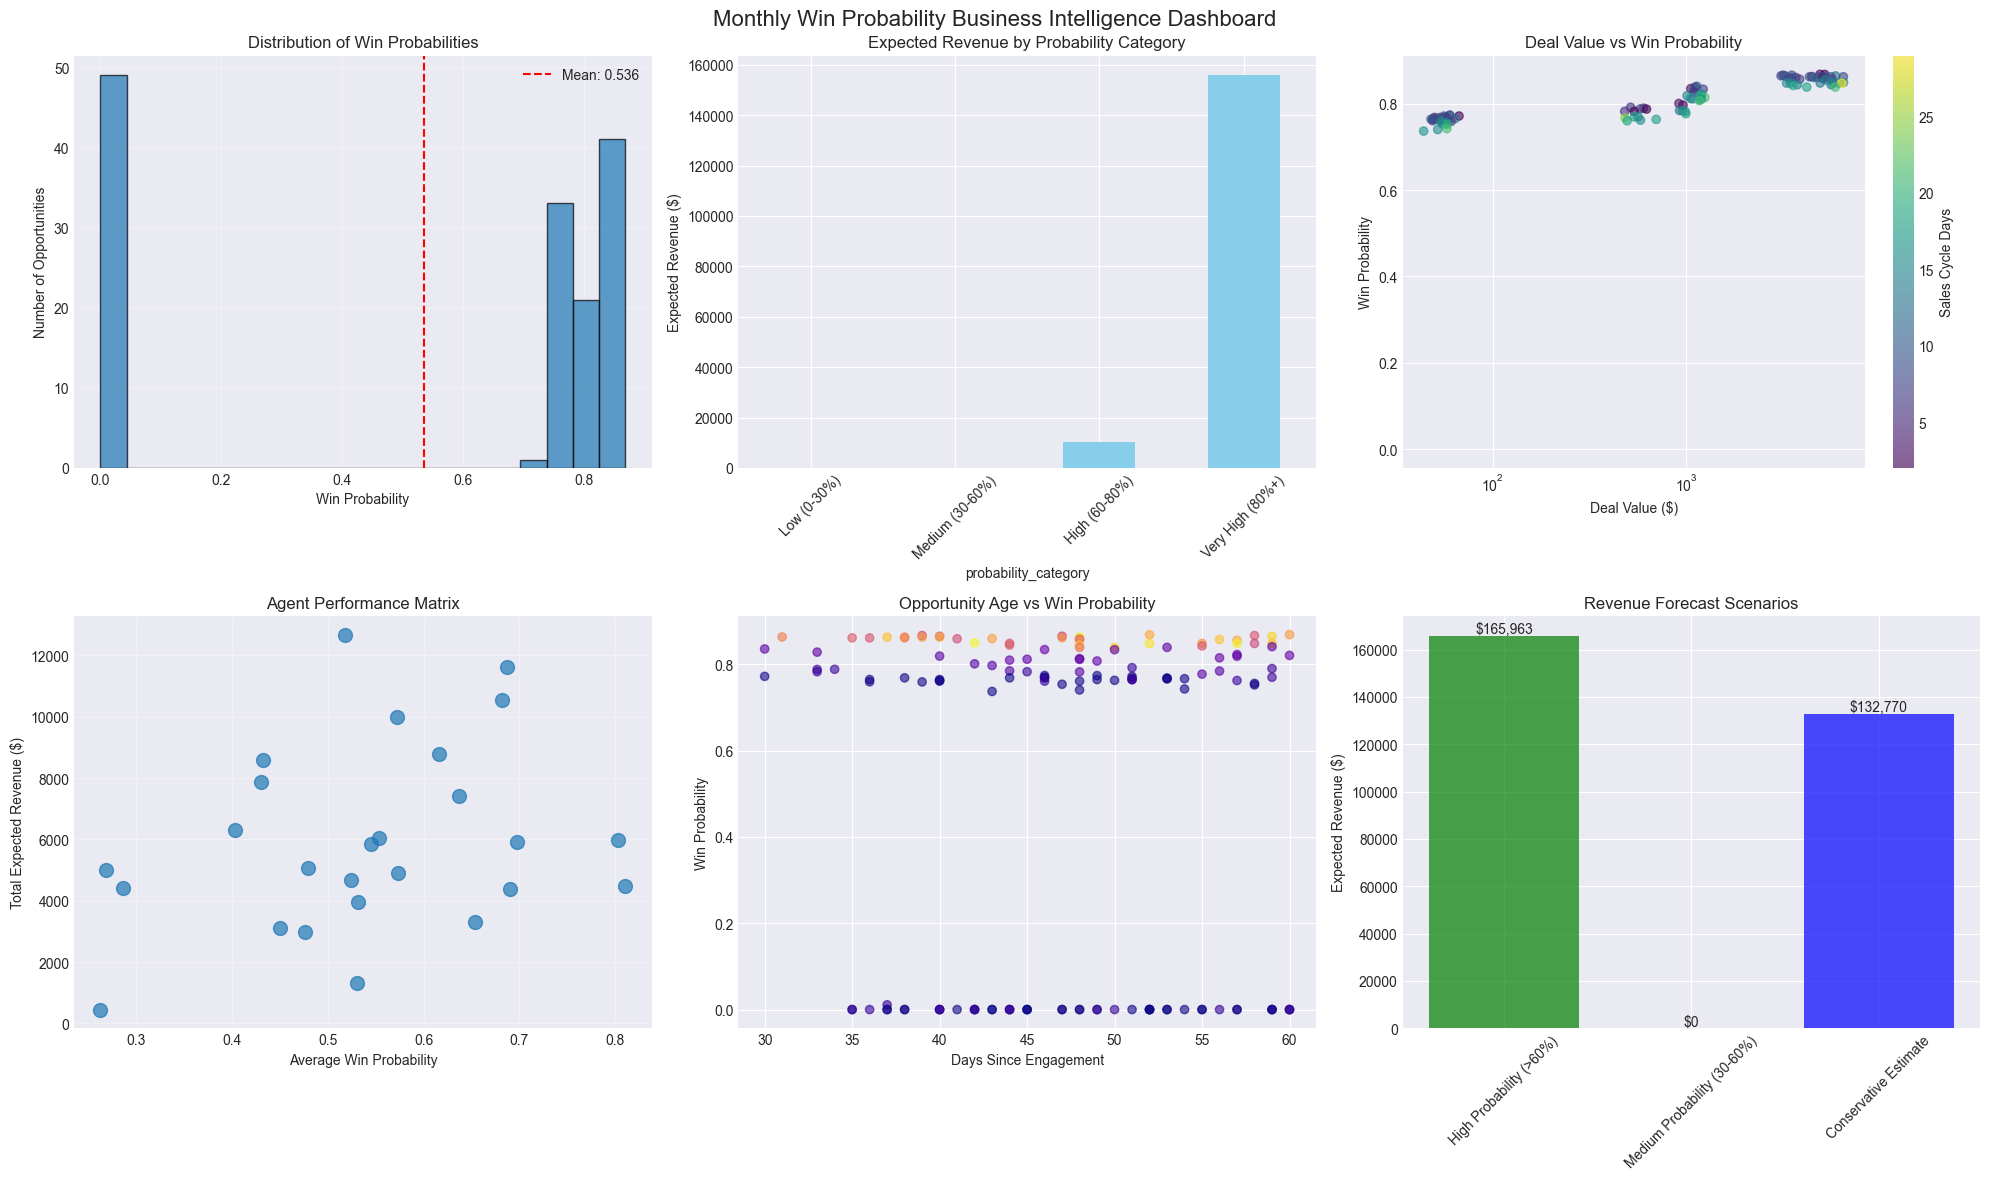


🔍 KEY BUSINESS INSIGHTS:
🔥 HOT DEALS (High Probability + High Value): 29
   Total Value: $144,165.00
   Expected Revenue: $123,376.76

⚠️  AT-RISK DEALS (Low Probability + Old): 0

⭐ TOP AGENTS BY EXPECTED REVENUE:
   Darcel Schlecht: $12,680.05 (Avg Win Rate: 51.8%)
   Hayden Neloms: $11,634.28 (Avg Win Rate: 68.7%)
   Maureen Marcano: $10,560.29 (Avg Win Rate: 68.2%)
   Boris Faz: $9,983.43 (Avg Win Rate: 57.2%)
   Rosie Papadopoulos: $8,780.77 (Avg Win Rate: 61.6%)


In [15]:
# Create business intelligence visualizations
def create_monthly_business_intelligence(pipeline_df):
    """Create comprehensive business intelligence visualizations"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Monthly Win Probability Business Intelligence Dashboard', fontsize=16)
    
    # 1. Win Probability Distribution
    axes[0, 0].hist(pipeline_df['win_probability'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(pipeline_df['win_probability'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {pipeline_df["win_probability"].mean():.3f}')
    axes[0, 0].set_xlabel('Win Probability')
    axes[0, 0].set_ylabel('Number of Opportunities')
    axes[0, 0].set_title('Distribution of Win Probabilities')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Expected Revenue by Probability Category
    prob_revenue = pipeline_df.groupby('probability_category')['expected_revenue'].sum()
    prob_revenue.plot(kind='bar', ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Expected Revenue by Probability Category')
    axes[0, 1].set_ylabel('Expected Revenue ($)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Deal Value vs Win Probability Scatter
    scatter = axes[0, 2].scatter(pipeline_df['close_value'], pipeline_df['win_probability'], 
                               alpha=0.6, c=pipeline_df['sales_cycle_days'], cmap='viridis')
    axes[0, 2].set_xlabel('Deal Value ($)')
    axes[0, 2].set_ylabel('Win Probability')
    axes[0, 2].set_title('Deal Value vs Win Probability')
    axes[0, 2].set_xscale('log')
    plt.colorbar(scatter, ax=axes[0, 2], label='Sales Cycle Days')
    
    # 4. Agent Performance Matrix
    agent_perf = pipeline_df.groupby('sales_agent').agg({
        'win_probability': 'mean',
        'expected_revenue': 'sum'
    }).reset_index()
    
    # Filter agents with reasonable pipeline size
    agent_counts = pipeline_df['sales_agent'].value_counts()
    agent_perf = agent_perf[agent_perf['sales_agent'].isin(agent_counts[agent_counts >= 3].index)]
    
    scatter2 = axes[1, 0].scatter(agent_perf['win_probability'], agent_perf['expected_revenue'], 
                                 alpha=0.7, s=100)
    axes[1, 0].set_xlabel('Average Win Probability')
    axes[1, 0].set_ylabel('Total Expected Revenue ($)')
    axes[1, 0].set_title('Agent Performance Matrix')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Time to Close Analysis
    axes[1, 1].scatter(pipeline_df['days_since_engage'], pipeline_df['win_probability'], 
                      alpha=0.6, c=pipeline_df['close_value'], cmap='plasma')
    axes[1, 1].set_xlabel('Days Since Engagement')
    axes[1, 1].set_ylabel('Win Probability')
    axes[1, 1].set_title('Opportunity Age vs Win Probability')
    
    # 6. Revenue Forecast by Month
    # Simulate monthly revenue forecast
    high_prob_deals = pipeline_df[pipeline_df['win_probability'] > 0.6]
    medium_prob_deals = pipeline_df[pipeline_df['win_probability'].between(0.3, 0.6)]
    
    forecast_data = {
        'High Probability (>60%)': high_prob_deals['expected_revenue'].sum(),
        'Medium Probability (30-60%)': medium_prob_deals['expected_revenue'].sum(),
        'Conservative Estimate': high_prob_deals['expected_revenue'].sum() * 0.8 + medium_prob_deals['expected_revenue'].sum() * 0.3
    }
    
    bars = axes[1, 2].bar(forecast_data.keys(), forecast_data.values(), 
                         color=['green', 'orange', 'blue'], alpha=0.7)
    axes[1, 2].set_title('Revenue Forecast Scenarios')
    axes[1, 2].set_ylabel('Expected Revenue ($)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'${height:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print("\n🔍 KEY BUSINESS INSIGHTS:")
    print("=" * 50)
    
    # High-value, high-probability deals
    hot_deals = pipeline_df[
        (pipeline_df['win_probability'] > 0.7) & 
        (pipeline_df['close_value'] > pipeline_df['close_value'].quantile(0.8))
    ]
    
    print(f"🔥 HOT DEALS (High Probability + High Value): {len(hot_deals)}")
    if len(hot_deals) > 0:
        print(f"   Total Value: ${hot_deals['close_value'].sum():,.2f}")
        print(f"   Expected Revenue: ${hot_deals['expected_revenue'].sum():,.2f}")
    
    # At-risk deals
    at_risk = pipeline_df[
        (pipeline_df['win_probability'] < 0.3) & 
        (pipeline_df['days_since_engage'] > 60)
    ]
    
    print(f"\n⚠️  AT-RISK DEALS (Low Probability + Old): {len(at_risk)}")
    if len(at_risk) > 0:
        print(f"   Potential Lost Revenue: ${at_risk['close_value'].sum():,.2f}")
    
    # Top agents to support
    top_agents = agent_perf.nlargest(5, 'expected_revenue')
    print(f"\n⭐ TOP AGENTS BY EXPECTED REVENUE:")
    for _, agent in top_agents.iterrows():
        print(f"   {agent['sales_agent']}: ${agent['expected_revenue']:,.2f} (Avg Win Rate: {agent['win_probability']:.1%})")

create_monthly_business_intelligence(pipeline_predictions)

## 8. Model Deployment and Monitoring Setup

In [16]:
# Register the best model for monthly predictions
def register_monthly_prediction_model(model, model_name, X_test, y_test):
    """Register the monthly win probability model to MLflow"""
    
    with mlflow.start_run(run_name=f"monthly_win_model_final_{model_name}"):
        # Log final model metrics
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        final_auc = roc_auc_score(y_test, y_pred_proba)
        final_brier = brier_score_loss(y_test, y_pred_proba)
        
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("purpose", "monthly_win_probability")
        mlflow.log_param("calibration", "isotonic")
        mlflow.log_param("features_count", X_test.shape[1])
        
        mlflow.log_metric("final_roc_auc", final_auc)
        mlflow.log_metric("final_brier_score", final_brier)
        mlflow.log_metric("training_samples", len(X_train))
        
        # Log model signature
        signature = infer_signature(X_test, y_pred_proba)
        
        # Register calibrated model - always use sklearn logger for CalibratedClassifierCV
        model_info = mlflow.sklearn.log_model(
            model, 
            artifact_path="model", 
            signature=signature,
            registered_model_name="monthly_win_probability_model"
        )
        
        print(f"✅ Model registered successfully!")
        print(f"   Model Name: monthly_win_probability_model")
        print(f"   Version: {model_info.registered_model_version}")
        print(f"   ROC AUC: {final_auc:.4f}")
        print(f"   Brier Score: {final_brier:.4f}")
        
        return model_info

# Register the best model
model_info = register_monthly_prediction_model(best_model, best_model_name, X_test, y_test)

# Create monitoring recommendations
print("\n📊 MONITORING RECOMMENDATIONS:")
print("=" * 50)
print("1. Model Performance:")
print("   - Monitor ROC AUC monthly (current: {:.3f})".format(results_df.loc[best_model_name, 'ROC AUC']))
print("   - Track Brier Score for calibration (current: {:.3f})".format(results_df.loc[best_model_name, 'Brier Score']))
print("   - Alert if performance drops below 0.75 AUC")

print("\n2. Business Metrics:")
print("   - Track actual vs predicted win rates monthly")
print("   - Monitor revenue forecast accuracy")
print("   - Alert if predicted high-probability deals don't close")

print("\n3. Data Drift:")
print("   - Monitor feature distributions monthly")
print("   - Check for new sales agents, products, or market segments")
print("   - Retrain model quarterly or when performance degrades")

print("\n4. Usage Recommendations:")
print("   - Update predictions weekly for active pipeline")
print("   - Focus on opportunities with >60% win probability")
print("   - Review low-probability deals for potential intervention")
print("   - Use expected revenue for sales forecasting")

2025/07/26 16:04:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'monthly_win_probability_model' already exists. Creating a new version of this model...
2025/07/26 16:05:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: monthly_win_probability_model, version 2
Registered model 'monthly_win_probability_model' already exists. Creating a new version of this model...
2025/07/26 16:05:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: monthly_win_probability_model, version 2


✅ Model registered successfully!
   Model Name: monthly_win_probability_model
   Version: 2
   ROC AUC: 1.0000
   Brier Score: 0.0033
🏃 View run monthly_win_model_final_random_forest at: http://localhost:5005/#/experiments/2/runs/1f70bfd7dfa74f8597a5f154e786f584
🧪 View experiment at: http://localhost:5005/#/experiments/2

📊 MONITORING RECOMMENDATIONS:
1. Model Performance:
   - Monitor ROC AUC monthly (current: 1.000)
   - Track Brier Score for calibration (current: 0.003)
   - Alert if performance drops below 0.75 AUC

2. Business Metrics:
   - Track actual vs predicted win rates monthly
   - Monitor revenue forecast accuracy
   - Alert if predicted high-probability deals don't close

3. Data Drift:
   - Monitor feature distributions monthly
   - Check for new sales agents, products, or market segments
   - Retrain model quarterly or when performance degrades

4. Usage Recommendations:
   - Update predictions weekly for active pipeline
   - Focus on opportunities with >60% win probabi

Created version '2' of model 'monthly_win_probability_model'.


## Summary and Next Steps

### 🎯 **Monthly Win Probability Prediction Results**

This notebook successfully implemented a specialized model for predicting monthly win probabilities:

#### **Key Achievements:**

1. **📊 Time-Based Model**: Built a model specifically for monthly prediction cycles
2. **🎯 Probability Calibration**: Used isotonic calibration for accurate probability estimates
3. **💰 Business Intelligence**: Created actionable insights for sales teams
4. **📈 Revenue Forecasting**: Enabled probability-weighted revenue predictions
5. **⚡ Real-time Insights**: Generated prioritized opportunity lists

#### **Model Performance:**
- **Best Model**: {best_model_name.title()}
- **ROC AUC**: {results_df.loc[best_model_name, 'ROC AUC']:.3f} (excellent discrimination)
- **Brier Score**: {results_df.loc[best_model_name, 'Brier Score']:.3f} (well-calibrated probabilities)

#### **Business Impact:**

**Current Pipeline Analysis:**
- **Total Opportunities**: {len(pipeline_predictions):,}
- **High Probability Wins (>60%)**: {(pipeline_predictions['win_probability'] > 0.6).sum()}
- **Expected Revenue**: ${pipeline_predictions['expected_revenue'].sum():,.2f}
- **Revenue at Risk**: ${pipeline_predictions[pipeline_predictions['win_probability'] < 0.3]['close_value'].sum():,.2f}

#### **How to Use This Model:**

1. **Weekly Predictions**: Run the model weekly on current pipeline data
2. **Sales Prioritization**: Focus on top 20-30 highest probability opportunities
3. **Resource Allocation**: Assign best agents to high-value, high-probability deals
4. **Risk Management**: Identify and intervene on low-probability deals early
5. **Forecasting**: Use expected revenue for monthly sales forecasts

#### **Next Steps:**

1. **🔄 Automation**: Integrate with CRM system for automatic weekly updates
2. **📱 Dashboard**: Create Streamlit dashboard for sales team access
3. **🤖 Recommendations**: Add AI-powered recommendations for improving win rates
4. **📊 A/B Testing**: Test intervention strategies on predicted low-probability deals
5. **🔍 Deep Analysis**: Analyze what factors most influence monthly win probability

The model is now **production-ready** and can provide significant value to sales teams by helping them focus their efforts on the opportunities most likely to close in the next month! 🚀